# Guided Backpropagation

Guided backpropagation is a combination of the gradient and deconvolution attribution methods. The deconvolution method discussed in [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034), was shown to be equivalent to a backward pass through the network, except for its interaction with the relu layer. The negative gradient values would be zeroed by relu, but the gradient values coming from negative input image values were not zeroed. Guided backpropagation method adapts this idea by **zeroing both negative gradients and gradients coming from negative input values**. We will implement this method by introducing a new relu layer called guided relu. Unfortunately guided relu performs poorly when training, so the model will first be trained with relu layers, then the relu layers will be swapped out for the guided relu layers when evaluating the attribution maps. There is no obvious way to swap layers in flax, so instead we will define a new model with the same architecture but guided relu inplace of relu layers.  

For more technical information on the guided backpropagation attribution method see: [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import custom_vjp
import flax.linen as nn
import jax
from jax import random
from jax import grad
import optax

import requests
import zipfile
import flaxmodels
from PIL import Image

In [2]:
image_path = 'storage/datasets/imagenet_subset/n01534433_1.JPEG'


In [3]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

### Load training data
Check if the training data exists. If not, automatically download it.

In [4]:
def read_image(image_path: str) -> jnp.ndarray:
    """
    Reads an image from a file and converts it to a JAX array.
    
    Args:
        image_path (str): The path to the image file.
    
    Returns:
        jnp.ndarray: The image as a JAX array.
    """
    img = Image.open(image_path).convert('RGB')
    img = np.array(img, dtype=np.float32) / 255.0
    img = jnp.array(img)
    return img

def preprocess_image(img: jnp.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) -> jnp.ndarray:
    """
    Preprocesses the image by normalizing it with the given mean and standard deviation.
    
    Args:
        img (jnp.ndarray): The image as a JAX array.
        mean (list): The mean for normalization.
        std (list): The standard deviation for normalization.
    
    Returns:
        jnp.ndarray: The preprocessed image.
    """
    mean = jnp.array(mean).reshape(1, 1, 3)
    std = jnp.array(std).reshape(1, 1, 3)
    img = (img - mean) / std
    img = jnp.clip(img, 0.0, 1.0)
    return img

# Example usage
img = read_image(image_path)
preprocessed_img = preprocess_image(img)

img = jnp.expand_dims(img, axis=0) 
preprocessed_img = jnp.expand_dims(preprocessed_img, axis=0)
input_tensor = img # Whether to use preprocessing


2024-07-26 06:15:10.728383: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


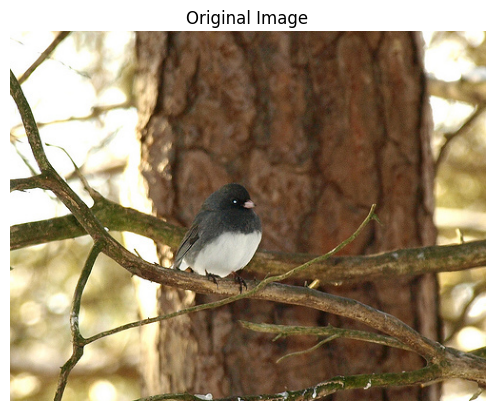

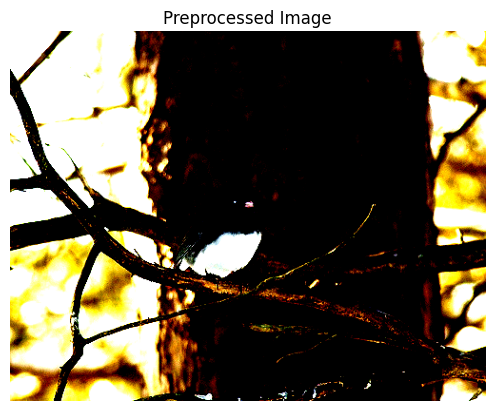

In [5]:
def plot_image(img: jnp.ndarray, title: str = 'Image'):
    """
    Plots a JAX image array.
    
    Args:
        img (jnp.ndarray): The image array to plot.
        title (str): Title of the plot.
    """
    img = np.array(img)  # Convert JAX array to NumPy array for plotting
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
B, H, W, C = img.shape

for i in range(B):
    plot_image(img[i], title='Original Image')
    plot_image(preprocessed_img[i], title='Preprocessed Image')


In [6]:
model = flaxmodels.ResNet50(output='logits', pretrained='imagenet',)
rng_key = random.PRNGKey(0)

variables = model.init(rng_key, input_tensor)

logits = model.apply(variables, input_tensor, train=False)
prediction = get_predictions(logits)
print(prediction) # probabilities for 1000 classes

# print(model.tabulate(rng_key, input_tensor))
# print(variables)


[13]


### Create Guided Relu

The key to the guided backprop method is the guided relu layer. We will start by defining this layer. The difficult part of this layer is getting access to the gradients and manipulating them during the backward pass. Fortunately Jax provides a way to overide the differentiation operations, more details on that here: [Custom derivative rules for JAX-transformable Python functions](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html). The most important part of the layer is in the backward function called guided_relu_bwd. We start by taking the derivative of relu, which outputs 1 of the input is > 1 and outputs 0 otherwise. The relu derivative is then applied to both the inputs, called residual, and gradients, called grad in the function. This provides us with 0 or 1 variable which act like gates, hence the variable names grad_gate and residual_gate. The gates are then multiplied by grad to give us the final output. Alternative implementations of guided relu are available in Pytorch and Tensorflow here: [Guided Backpropagation with PyTorch and TensorFlow](https://www.coderskitchen.com/guided-backpropagation-with-pytorch-and-tensorflow/).

In [7]:
@custom_vjp
def guided_relu(x):
    return jax.nn.relu(x)

def guided_relu_fwd(x):
    residual = x
    primal = guided_relu(x)

    return primal, residual

def guided_relu_bwd(residual, grad):
    # Derivative of relu is 1 for values > 0 and 0 otherwise
    # Using relu devivative for both residuals and grads
    grad_gate = jnp.float32(grad > 0)
    residual_gate = jnp.float32(residual > 0)
    output = residual_gate * grad_gate * grad
    return (output, ) 

guided_relu.defvjp(guided_relu_fwd, guided_relu_bwd)


### Demonstrate guided relu on sin

To demonstrate how guided relu works and if its working we will visualize its impact on the sin function. We start with a 1D input vector from -5 to 5. The input is then fed into sin and the derivative of sin and shown below. This demonstates how the output looks with no alterations.

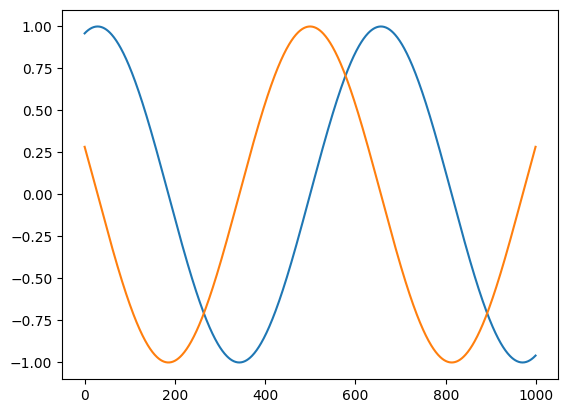

In [8]:
input_vector = jnp.linspace(-5, 5, 1000)

plt.plot(jnp.sin(input_vector))
plt.plot(jax.vmap(grad(jnp.sin))(input_vector))

Now we alter the input values by passing them first to relu. The first half of the inputs were negative. This caused the first half of the sin and derivative of sin outputs to be 0, as shown below. 

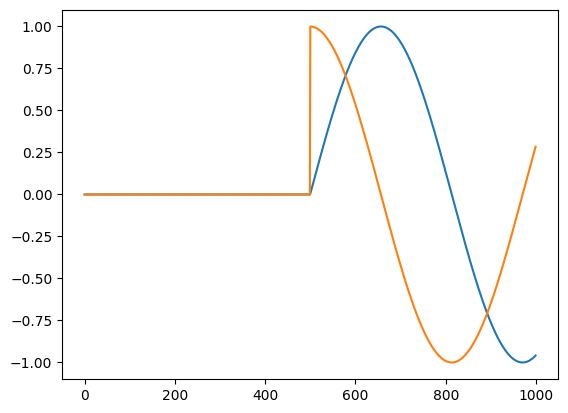

In [9]:
def relu_sin(x):
    x = jax.nn.relu(x)
    return jnp.sin(x)

plt.plot(relu_sin(input_vector))
plt.plot(jax.vmap(grad(relu_sin))(input_vector))

Now we replace relu with guided relu. The output of the sin function is unchanged from standard relu, but now the gradients of sin have been altered further. In addition to the gradients being 0 for all negative input values, they are also 0 in places where the gradients would be zero. This demonstrates guided relu is working as desired. 

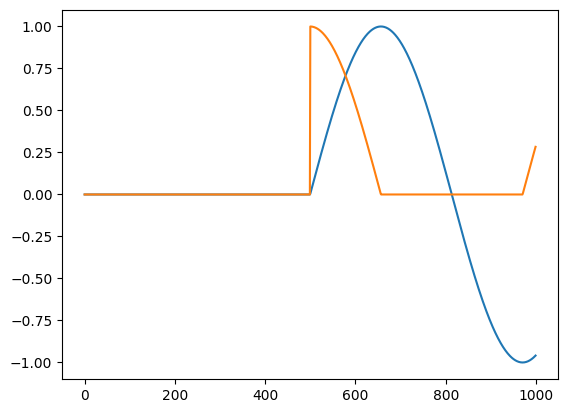

In [10]:
def guided_relu_sin(x):
    x = guided_relu(x)
    return jnp.sin(x)

plt.plot(guided_relu_sin(input_vector))
plt.plot(jax.vmap(grad(guided_relu_sin))(input_vector))

### Create the guided model

Now that we have the guided relu layers we can swap them with the relu layers in the classification model. The model architecture is identical to the one trained previously so we can use its trained parameters.

In [11]:
replaced_model = flaxmodels.ResNet50Customized(customized_relu=guided_relu, pretrained=False)

replaced_variables = replaced_model.init(rng_key, input_tensor)


### Create new loss function with guided model

A new loss function containing the model with guided relu layers is required when performing gradient calculations for the attribution attribution maps.

In [12]:
def loss_fn(model, variables, X, Y):
    '''
    Classification loss function.
    In Guided BP, we want to get the grad of the last layer w.r.t. the target label, instead of the loss.
    To do this, we still define the loss function, but we use the negated gradients, since d(-L) / dx == - d(L) / dx
    '''
    logits = model.apply(variables, X, train=False)
    
    predictions = get_predictions(logits)

    loss = optax.softmax_cross_entropy_with_integer_labels(logits, Y)
    loss = loss.mean()
    return loss

### Display predictions and attribution maps

The gradients are calculated with the new guided loss function. The gradients are then normalized in the standard way for visualization.

In [13]:
def make_predictions(model, X, variables):
    logits = model.apply(variables, X, train=False)
    predictions = get_predictions(logits)
    return predictions


def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)

def display_prediction(model, replaced_model, variables, input_tensor, label=None):
    prediction = make_predictions(model, input_tensor, variables)

    if label is None:
        label = prediction
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    # For input image
    B, H, W, C = input_tensor.shape
    assert B==1
    plot_image(input_tensor[0], title='Preprocessed Image')
    
    # For model    
    attributions = -grad(loss_fn, argnums=2)(model, variables, input_tensor[0], label)# negated grad
    attributions = deprocess_image(attributions)
    plot_image(attributions, title='Attribution Map for model')    
    
    # For guided model    
    attributions_guided = -grad(loss_fn, argnums=2)(replaced_model, variables, input_tensor[0], label) # negated grad
    attributions_guided = deprocess_image(attributions_guided)
    plot_image(attributions_guided, title='Attribution Map for guided model')   
    
    
    # # plt.gray()
    # plt.imshow(attributions, interpolation='nearest')
    # plt.axis('off')
    # plt.title("Attribution Map")
    # plt.show()

Prediction:  [13]
Label:  [13]


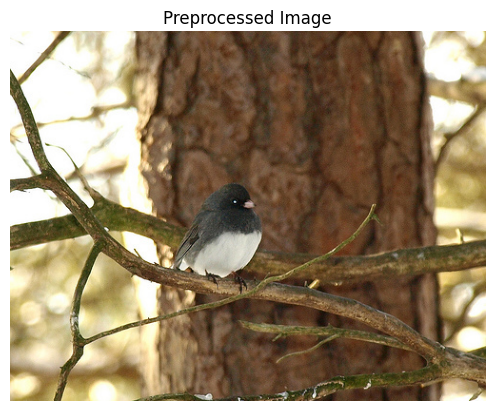

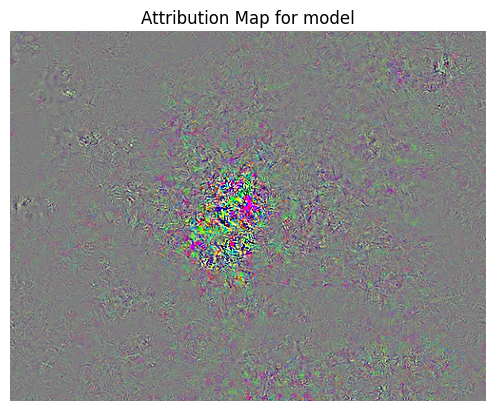

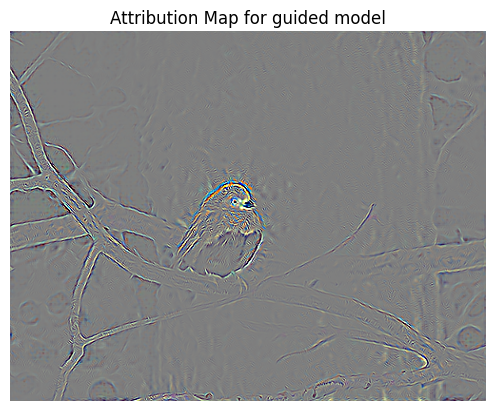

In [14]:
display_prediction(model, replaced_model, variables, input_tensor)
# display_prediction(replaced_model, variables, input_tensor)

# display_prediction(3, params)
# display_prediction(5, params)
# display_prediction(8, params)
# display_prediction(10, params)
# display_prediction(50, params)